# Lectura de Mediciones Transformadores

Notas:
1. Descargar de SITEC los archivos de Generacion de San Francisco
2. Graficar la Demanda x Trafos, la Generacion y la Suma
3. Graficar la tension en barra de 132 KV cuando entra la Generacion
4. Graficar la demanda en los trafos de Malvinas y relacionar

## Seteo Inicial

In [267]:
# -*- coding: utf-8 -*-
"""
Created on Viernes 8 Octubre 2021 17:43:11 

@author: Daniel Busso
"""

# Plantilla de Pre Procesado

# Cómo importar las librerías
import numpy    as np
import pandas   as pd
import datetime as dt
import os

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [268]:
# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import mean_absolute_percentage_error

#from skforecast.ForecasterAutoreg import ForecasterAutoreg
#from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
#from skforecast.model_selection import grid_search_forecaster
#from skforecast.model_selection import time_series_spliter
#from skforecast.model_selection import cv_forecaster
#from skforecast.model_selection import backtesting_forecaster
#from skforecast.model_selection import backtesting_forecaster_intervals

In [269]:
# Configuracion Pandas

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', '{:.2f}'.format)

In [270]:
def conversion_2400(fecha):
    if fecha[11:13] != '24':
        return pd.to_datetime(fecha, format='%d/%m/%Y %H:%M')

    fecha = fecha[0:11] + '00:' + fecha[14:]
    return pd.to_datetime(fecha, format='%d/%m/%Y %H:%M') + dt.timedelta(days=1)

## TD1

In [271]:
# EMPIEZO PROCESANDO UNA CARPETA
# AUTOMATIZAR LECTURAS DE VARIOS ARCHIVOS .PRN ANUALES
# lEER Y CONCATENAR LOS ARCHIVOS .prn DE LA CARPETA DSPractica/eetts/sanfrancisco/TD1

import os
import sys
from pathlib import Path

# ELEGIR PLATAFORMA WINDOWS LOCAL O GOOGLE COLABORATORY
if sys.platform == 'linux' :
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  carpeta_trabajo = Path('/content/drive/Othercomputers/LENOVO/DSPractica/eetts/san_francisco/TD1') # Google Colab
else:
  carpeta_inicio  = Path.home()
  carpeta_eett = Path("DSPractica/eetts/san_francisco/TD1")
  carpeta_trabajo = carpeta_inicio / carpeta_eett

archivos = list(carpeta_trabajo.glob('*.prn'))

# Automatizacion de los DataFrames 
i = 0
for nombre_completo in archivos:
    if (i == 0) :
        dfconca = pd.read_fwf(nombre_completo, header=0, decimal=',')
    else:
        dfdatos = pd.read_fwf(nombre_completo, header=0, decimal=',')
        dfconca = pd.concat([dfconca, dfdatos], ignore_index=True)
    i = i + 1
    
# BORRAMOS COLUMNAS NO USADAS
dfconca = dfconca.drop(columns=['Ampere', 'KVolt'])

In [308]:
dfconca.loc['2020-12-27', :]

,Fecha,Hora,MW,MVAR,MVA
Fecha_Hora,,,,,


In [273]:
# GENERAMOS INDICE DE FECHAS PARA MANEJAR LA SERIE DE TIEMPO
# Lectura y creacion del index DateTime para tratar el DataFrame como una Serie de Tiempo

dfconca['Fecha_Hora'] = dfconca['Fecha'] + ' ' + dfconca['Hora']
dfconca['Fecha_Hora'] = dfconca.Fecha_Hora.apply(conversion_2400) # CONVERSION DE HORA 24:00 ---> 00:00

dfconca.set_index('Fecha_Hora', inplace=True)
serie     = dfconca.drop(dfconca.index[-1]) # borro la fila del nuevo anio
serie_ord = serie.sort_index()
TD1 = serie_ord.copy()

# BORRAMOS Columnas Fecha Hora porque ya tenemos el Index Temporal
TD1 = TD1.drop(columns=['Fecha', 'Hora'])

# Renombramos Columnas
TD1.columns = ['TD1_MW', 'TD1_MVAR', 'TD1_MVA']
TD1

,TD1_MW,TD1_MVAR,TD1_MVA
Fecha_Hora,,,
2011-01-01 00:15:00,-3.47,-0.31,3.48
2011-01-01 00:30:00,-8.98,-1.47,9.10
2011-01-01 00:45:00,-9.05,-1.46,9.17
2011-01-01 01:00:00,-9.03,-1.41,9.14
2011-01-01 01:15:00,-9.03,-1.36,9.13
...,...,...,...
2020-12-31 23:35:00,-5.64,-1.72,5.90
2020-12-31 23:40:00,-5.63,-1.68,5.88
2020-12-31 23:45:00,-5.66,-1.72,5.92


## TD2 

In [274]:
# EMPIEZO PROCESANDO UNA CARPETA
# AUTOMATIZAR LECTURAS DE VARIOS ARCHIVOS .PRN ANUALES
# lEER Y CONCATENAR LOS ARCHIVOS .prn DE LA CARPETA DSPractica/eetts/sanfrancisco/TD2

import os
import sys
from pathlib import Path

# ELEGIR PLATAFORMA WINDOWS LOCAL O GOOGLE COLABORATORY
if sys.platform == 'linux' :
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  carpeta_trabajo = Path('/content/drive/Othercomputers/LENOVO/DSPractica/eetts/san_francisco/TD2') # Google Colab
else:
  carpeta_inicio  = Path.home()
  carpeta_eett = Path("DSPractica/eetts/san_francisco/TD2")
  carpeta_trabajo = carpeta_inicio / carpeta_eett

archivos = list(carpeta_trabajo.glob('*.prn'))

# Automatizacion de los DataFrames 
i = 0
for nombre_completo in archivos:
    if (i == 0) :
        dfconca = pd.read_fwf(nombre_completo, header=0, decimal=',')
    else:
        dfdatos = pd.read_fwf(nombre_completo, header=0, decimal=',')
        dfconca = pd.concat([dfconca, dfdatos], ignore_index=True)
    i = i + 1
    
# BORRAMOS COLUMNAS NO USADAS
dfconca = dfconca.drop(columns=['Ampere', 'KVolt'])

In [275]:
dfconca

,Fecha,Hora,MW,MVAR,MVA
0,01/01/2011,00:15,-3.56,-0.33,3.57
1,01/01/2011,00:30,-9.10,-1.47,9.22
2,01/01/2011,00:45,-9.16,-1.46,9.28
3,01/01/2011,01:00,-9.15,-1.40,9.25
4,01/01/2011,01:15,-9.16,-1.36,9.26
...,...,...,...,...,...
632057,31/12/2020,23:40,-0.14,-0.09,0.16
632058,31/12/2020,23:45,-0.14,-0.08,0.16
632059,31/12/2020,23:50,-0.13,-0.09,0.16
632060,31/12/2020,23:55,-0.14,-0.09,0.16


In [276]:
# GENERAMOS INDICE DE FECHAS PARA MANEJAR LA SERIE DE TIEMPO
# Lectura y creacion del index DateTime para tratar el DataFrame como una Serie de Tiempo

dfconca['Fecha_Hora'] = dfconca['Fecha'] + ' ' + dfconca['Hora']
dfconca['Fecha_Hora'] = dfconca.Fecha_Hora.apply(conversion_2400) # CONVERSION DE HORA 24:00 ---> 00:00

dfconca.set_index('Fecha_Hora', inplace=True)
serie     = dfconca.drop(dfconca.index[-1]) # borro la fila del nuevo anio
serie_ord = serie.sort_index()
TD2 = serie_ord.copy()

# BORRAMOS Columnas Fecha Hora porque ya tenemos el Index Temporal
TD2 = TD2.drop(columns=['Fecha', 'Hora'])

# Renombramos Columnas
TD2.columns = ['TD2_MW', 'TD2_MVAR', 'TD2_MVA']
TD2

,TD2_MW,TD2_MVAR,TD2_MVA
Fecha_Hora,,,
2011-01-01 00:15:00,-3.56,-0.33,3.57
2011-01-01 00:30:00,-9.10,-1.47,9.22
2011-01-01 00:45:00,-9.16,-1.46,9.28
2011-01-01 01:00:00,-9.15,-1.40,9.25
2011-01-01 01:15:00,-9.16,-1.36,9.26
...,...,...,...
2020-12-31 23:35:00,-0.14,-0.09,0.17
2020-12-31 23:40:00,-0.14,-0.09,0.16
2020-12-31 23:45:00,-0.14,-0.08,0.16


## TD3

In [277]:
# EMPIEZO PROCESANDO UNA CARPETA
# AUTOMATIZAR LECTURAS DE VARIOS ARCHIVOS .PRN ANUALES
# lEER Y CONCATENAR LOS ARCHIVOS .prn DE LA CARPETA DSPractica/eetts/sanfrancisco

import os
import sys
from pathlib import Path

# ELEGIR PLATAFORMA WINDOWS LOCAL O GOOGLE COLABORATORY
if sys.platform == 'linux' :
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  carpeta_trabajo = Path('/content/drive/Othercomputers/LENOVO/DSPractica/eetts/san_francisco/TD3') # Google Colab
else:
  carpeta_inicio  = Path.home()
  carpeta_eett = Path("DSPractica/eetts/san_francisco/TD3")
  carpeta_trabajo = carpeta_inicio / carpeta_eett

archivos = list(carpeta_trabajo.glob('*.prn'))

# Automatizacion de los DataFrames 
i = 0
for nombre_completo in archivos:
    if (i == 0) :
        dfconca = pd.read_fwf(nombre_completo, header=0, decimal=',')
    else:
        dfdatos = pd.read_fwf(nombre_completo, header=0, decimal=',')
        dfconca = pd.concat([dfconca, dfdatos], ignore_index=True)
    i = i + 1
    
# BORRAMOS COLUMNAS NO USADAS
dfconca = dfconca.drop(columns=['Ampere', 'KVolt'])

In [278]:
dfconca

,Fecha,Hora,MW,MVAR,MVA
0,04/01/2017,02:05,0.00,0.00,0.00
1,04/01/2017,02:10,0.00,0.00,0.00
2,04/01/2017,02:15,0.00,0.00,0.00
3,04/01/2017,02:20,0.00,0.00,0.00
4,04/01/2017,02:25,0.00,0.00,0.00
...,...,...,...,...,...
412265,31/12/2020,23:40,10.23,-1.99,10.42
412266,31/12/2020,23:45,10.30,-1.99,10.49
412267,31/12/2020,23:50,10.12,-1.84,10.29
412268,31/12/2020,23:55,10.10,-1.84,10.27


In [279]:
# GENERAMOS INDICE DE FECHAS PARA MANEJAR LA SERIE DE TIEMPO

dfconca['Fecha_Hora'] = dfconca['Fecha'] + ' ' + dfconca['Hora']
dfconca['Fecha_Hora'] = dfconca.Fecha_Hora.apply(conversion_2400) # CONVERSION DE HORA 24:00 ---> 00:00

dfconca.set_index('Fecha_Hora', inplace=True)
serie     = dfconca.drop(dfconca.index[-1]) # borro la fila del nuevo anio
serie_ord = serie.sort_index()
TD3 = serie_ord.copy()

# BORRAMOS Columnas Fecha Hora porque ya tenemos el Index Temporal
TD3 = TD3.drop(columns=['Fecha', 'Hora'])

# Renombramos Columnas
TD3.columns = ['TD3_MW', 'TD3_MVAR', 'TD3_MVA']
TD3

,TD3_MW,TD3_MVAR,TD3_MVA
Fecha_Hora,,,
2017-01-04 02:05:00,0.00,0.00,0.00
2017-01-04 02:10:00,0.00,0.00,0.00
2017-01-04 02:15:00,0.00,0.00,0.00
2017-01-04 02:20:00,0.00,0.00,0.00
2017-01-04 02:25:00,0.00,0.00,0.00
...,...,...,...
2020-12-31 23:35:00,10.28,-1.99,10.47
2020-12-31 23:40:00,10.23,-1.99,10.42
2020-12-31 23:45:00,10.30,-1.99,10.49


## Concatenar columnas para despues sumar 

In [280]:
# CONCATENAR TD1 + TD2 + TD3
#
Trafos = pd.concat([TD1, TD2, TD3], axis = 1)
Trafos

,TD1_MW,TD1_MVAR,TD1_MVA,TD2_MW,TD2_MVAR,TD2_MVA,TD3_MW,TD3_MVAR,TD3_MVA
Fecha_Hora,,,,,,,,,
2011-01-01 00:15:00,-3.47,-0.31,3.48,-3.56,-0.33,3.57,NaN,NaN,NaN
2011-01-01 00:30:00,-8.98,-1.47,9.10,-9.10,-1.47,9.22,NaN,NaN,NaN
2011-01-01 00:45:00,-9.05,-1.46,9.17,-9.16,-1.46,9.28,NaN,NaN,NaN
2011-01-01 01:00:00,-9.03,-1.41,9.14,-9.15,-1.40,9.25,NaN,NaN,NaN
2011-01-01 01:15:00,-9.03,-1.36,9.13,-9.16,-1.36,9.26,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2020-12-31 23:35:00,-5.64,-1.72,5.90,-0.14,-0.09,0.17,10.28,-1.99,10.47
2020-12-31 23:40:00,-5.63,-1.68,5.88,-0.14,-0.09,0.16,10.23,-1.99,10.42
2020-12-31 23:45:00,-5.66,-1.72,5.92,-0.14,-0.08,0.16,10.30,-1.99,10.49


In [281]:
# Reemplazar np.nan con ceros
Trafos = Trafos.replace(np.nan,0)
Trafos

,TD1_MW,TD1_MVAR,TD1_MVA,TD2_MW,TD2_MVAR,TD2_MVA,TD3_MW,TD3_MVAR,TD3_MVA
Fecha_Hora,,,,,,,,,
2011-01-01 00:15:00,-3.47,-0.31,3.48,-3.56,-0.33,3.57,0.00,0.00,0.00
2011-01-01 00:30:00,-8.98,-1.47,9.10,-9.10,-1.47,9.22,0.00,0.00,0.00
2011-01-01 00:45:00,-9.05,-1.46,9.17,-9.16,-1.46,9.28,0.00,0.00,0.00
2011-01-01 01:00:00,-9.03,-1.41,9.14,-9.15,-1.40,9.25,0.00,0.00,0.00
2011-01-01 01:15:00,-9.03,-1.36,9.13,-9.16,-1.36,9.26,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...
2020-12-31 23:35:00,-5.64,-1.72,5.90,-0.14,-0.09,0.17,10.28,-1.99,10.47
2020-12-31 23:40:00,-5.63,-1.68,5.88,-0.14,-0.09,0.16,10.23,-1.99,10.42
2020-12-31 23:45:00,-5.66,-1.72,5.92,-0.14,-0.08,0.16,10.30,-1.99,10.49


In [282]:
Trafos['Suma'] = Trafos['TD1_MVA'] + Trafos['TD2_MVA'] + Trafos['TD3_MVA']
Trafos

,TD1_MW,TD1_MVAR,TD1_MVA,TD2_MW,TD2_MVAR,TD2_MVA,TD3_MW,TD3_MVAR,TD3_MVA,Suma
Fecha_Hora,,,,,,,,,,
2011-01-01 00:15:00,-3.47,-0.31,3.48,-3.56,-0.33,3.57,0.00,0.00,0.00,7.05
2011-01-01 00:30:00,-8.98,-1.47,9.10,-9.10,-1.47,9.22,0.00,0.00,0.00,18.32
2011-01-01 00:45:00,-9.05,-1.46,9.17,-9.16,-1.46,9.28,0.00,0.00,0.00,18.45
2011-01-01 01:00:00,-9.03,-1.41,9.14,-9.15,-1.40,9.25,0.00,0.00,0.00,18.39
2011-01-01 01:15:00,-9.03,-1.36,9.13,-9.16,-1.36,9.26,0.00,0.00,0.00,18.39
...,...,...,...,...,...,...,...,...,...,...
2020-12-31 23:35:00,-5.64,-1.72,5.90,-0.14,-0.09,0.17,10.28,-1.99,10.47,16.54
2020-12-31 23:40:00,-5.63,-1.68,5.88,-0.14,-0.09,0.16,10.23,-1.99,10.42,16.46
2020-12-31 23:45:00,-5.66,-1.72,5.92,-0.14,-0.08,0.16,10.30,-1.99,10.49,16.57


In [283]:
Trafos.loc['2020-07-01 17':'2020-07-01 23', ['TD1_MVA', 'TD2_MVA', 'TD3_MVA', 'Suma']]

,TD1_MVA,TD2_MVA,TD3_MVA,Suma
Fecha_Hora,,,,
2020-07-01 17:00:00,1.95,0.15,11.27,13.37
2020-07-01 17:05:00,2.01,0.16,11.25,13.42
2020-07-01 17:10:00,2.03,0.14,11.23,13.40
2020-07-01 17:15:00,2.03,0.15,11.31,13.49
2020-07-01 17:20:00,2.00,0.14,11.29,13.43
2020-07-01 17:25:00,2.06,0.14,11.28,13.48
2020-07-01 17:30:00,2.05,0.15,11.28,13.48
2020-07-01 17:35:00,2.07,0.14,11.33,13.54
2020-07-01 17:40:00,2.04,0.15,11.34,13.53


In [284]:
# Grafica del Pico Maximo Potencia Aparente x DIA

def Grafica_Anual_xDia(anio):
    plt.style.use('fivethirtyeight')
    
    #y = datos.loc[anio:anio, 'MVA'].resample('D').max()
    #x = y.index
    
    x = Trafos.loc[anio:anio, 'TD1_MVA'].resample('D').max()
    y = Trafos.loc[anio:anio, 'TD2_MVA'].resample('D').max()
    z = Trafos.loc[anio:anio, 'TD3_MVA'].resample('D').max()
    s = Trafos.loc[anio:anio, 'Suma'].resample('D').max()
    t = y.index 
    
    fig = plt.figure()
    fig, grafico = plt.subplots(figsize=(30, 5))
    
    #grafico.plot(x, y, lw=1, label='Potencia Aparente', marker='o')
    grafico.plot(t, x, lw=1, label='TD1', marker='o', color='g')
    grafico.plot(t, y, lw=1, label='TD2', marker='o', color='y')
    grafico.plot(t, z, lw=1, label='TD3', marker='o', color='b')
    grafico.plot(t, s, lw=2, label='TD1+TD2+TD3', marker='o', color='k')
    
    grafico.set_xlabel('[ Meses ]')  # Add an x-label to the axes.
    grafico.set_ylabel('[ MVA ]')  # Add a y-label to the axes.
    grafico.set_title("POTENCIA APARENTE DIARIA " + anio)  # Add a title to the axes.
    grafico.legend()  # Add a legend.
    #grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
    #grafico.grid()
    
    #fig.savefig("Serie_Anual_xDia_"+anio+".png")

<Figure size 432x288 with 0 Axes>

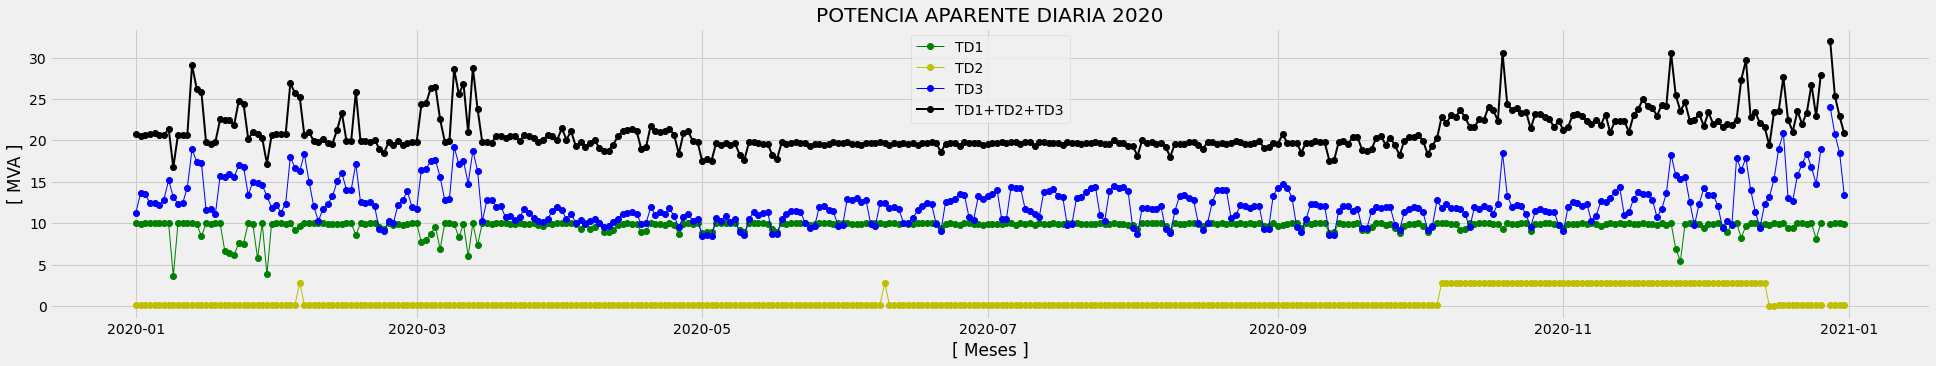

In [285]:
Grafica_Anual_xDia('2020')

In [286]:
# Grafica del Pico Maximo Potencia Aparente x DIA

def Grafica_xDia_Mensual(pi, pf):
    plt.style.use('fivethirtyeight')
    
    #y = datos.loc[anio:anio, 'MVA'].resample('D').max()
    #x = y.index
    
    x = Trafos.loc[pi:pf, 'TD1_MVA'].resample('D').max()
    y = Trafos.loc[pi:pf, 'TD2_MVA'].resample('D').max()
    z = Trafos.loc[pi:pf, 'TD3_MVA'].resample('D').max()
    s = Trafos.loc[pi:pf, 'Suma'].resample('D').max()
    t = y.index 
    
    fig = plt.figure()
    fig, grafico = plt.subplots(figsize=(30, 5))
    
    #grafico.plot(x, y, lw=1, label='Potencia Aparente', marker='o')
    grafico.plot(t, x, lw=1, label='TD1', marker='o', color='g')
    grafico.plot(t, y, lw=1, label='TD2', marker='o', color='y')
    grafico.plot(t, z, lw=1, label='TD3', marker='o', color='b')
    grafico.plot(t, s, lw=2, label='TD1+TD2+TD3', marker='o', color='k')
    
    grafico.set_xlabel('[ Meses ]')  # Add an x-label to the axes.
    grafico.set_ylabel('[ MVA ]')  # Add a y-label to the axes.
    grafico.set_title("POTENCIA APARENTE DIARIA " + pi + pf)  # Add a title to the axes.
    grafico.legend()  # Add a legend.
    #grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
    #grafico.grid()
    
    #fig.savefig("Serie_Anual_xDia_"+anio+".png")

<Figure size 432x288 with 0 Axes>

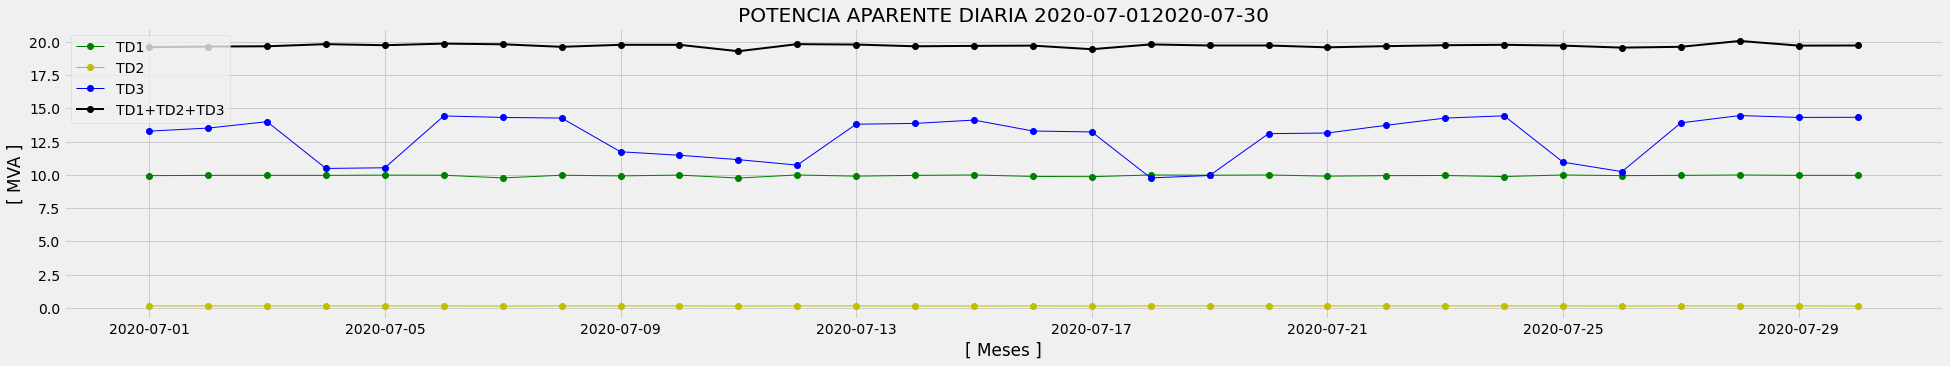

In [287]:
Grafica_xDia_Mensual('2020-07-01', '2020-07-30')

In [288]:
#
# Grafica del Pico Maximo Potencia Aparente x DIA

def Grafica_xDia_Mensual(pi, pf):
    plt.style.use('fivethirtyeight')
    
    #y = datos.loc[anio:anio, 'MVA'].resample('D').max()
    #x = y.index
    
    gg = Trafos.loc[pi:pf, ['TD1_MVA', 'TD2_MVA', 'TD3_MVA', 'Suma']]
    

    x = gg['TD1_MVA']
    y = gg['TD2_MVA']
    z = gg['TD3_MVA']
    s = gg['Suma']
    t = x.index 
    
    fig = plt.figure()
    fig, grafico = plt.subplots(figsize=(30, 5))
    
    #grafico.plot(x, y, lw=1, label='Potencia Aparente', marker='o')
    grafico.plot(t, x, lw=1, label='TD1', marker='o', color='g')
    grafico.plot(t, y, lw=1, label='TD2', marker='o', color='y')
    grafico.plot(t, z, lw=1, label='TD3', marker='o', color='b')
    grafico.plot(t, s, lw=2, label='TD1+TD2+TD3', marker='o', color='k')
    
    grafico.set_xlabel('[ Meses ]')  # Add an x-label to the axes.
    grafico.set_ylabel('[ MVA ]')  # Add a y-label to the axes.
    grafico.set_title("POTENCIA APARENTE DIARIA " + pi + pf)  # Add a title to the axes.
    grafico.legend()  # Add a legend.
    #grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
    #grafico.grid()
    
    #fig.savefig("Serie_Anual_xDia_"+anio+".png")

<Figure size 432x288 with 0 Axes>

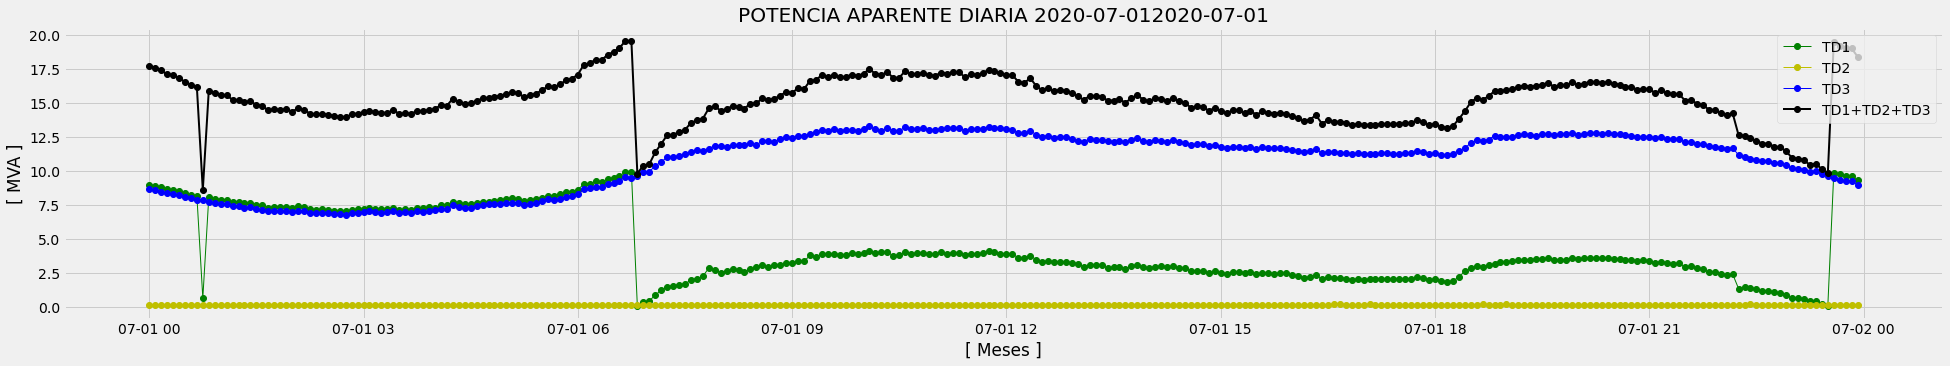

In [289]:
Grafica_xDia_Mensual('2020-07-01', '2020-07-01')

In [290]:
pi='2020'
pf='2020'
anio = '2020'
gg = Trafos.loc[anio, ['Suma']].resample('D').max()
gg


Trafos.loc[ind, ['TD1_MVA', 'TD2_MVA', 'TD3_MVA', 'Suma']]


ind = Trafos.loc['2020-07-01', 'Suma'].idxmax()
ind

Timestamp('2020-07-01 06:40:00')

In [292]:
gg.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Fecha_Hora', length=366, freq='D')

In [293]:
ss = Trafos.loc['2020-01-01':'2020-12-31', 'Suma'].resample('D').max()


#Trafos.loc[pi:pf, ['TD1_MVA', 'TD2_MVA', 'TD3_MVA', 'Suma']].resample('D').max()

In [294]:
ss.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Fecha_Hora', length=366, freq='D')

In [295]:
#Suma_Maximo = Trafos.loc[pi:pf, 'Suma'].resample('D').max()

Trafos.loc[pi:pf, ['TD1_MVA', 'TD2_MVA', 'TD3_MVA', 'Suma']]

,TD1_MVA,TD2_MVA,TD3_MVA,Suma
Fecha_Hora,,,,
2020-01-01 00:00:00,9.65,0.15,0.35,10.15
2020-01-01 00:05:00,9.58,0.16,10.28,20.02
2020-01-01 00:10:00,9.59,0.15,10.30,20.04
2020-01-01 00:15:00,9.57,0.16,10.29,20.02
2020-01-01 00:20:00,9.50,0.15,10.20,19.85
...,...,...,...,...
2020-12-31 23:35:00,5.90,0.17,10.47,16.54
2020-12-31 23:40:00,5.88,0.16,10.42,16.46
2020-12-31 23:45:00,5.92,0.16,10.49,16.57


In [296]:
Suma_Maximo = Trafos.loc[pi:pf, 'Suma'].resample('D').max()
Suma_Maximo

Fecha_Hora
2020-01-01   20.80
2020-01-02   20.57
2020-01-03   20.70
2020-01-04   20.80
2020-01-05   20.87
              ... 
2020-12-27   NaN  
2020-12-28   32.00
2020-12-29   25.38
2020-12-30   22.92
2020-12-31   20.83
Freq: D, Name: Suma, Length: 366, dtype: float64

In [297]:
Trafos.loc[ind, ['TD1_MVA', 'TD2_MVA', 'TD3_MVA', 'Suma']]

TD1_MVA   9.89 
TD2_MVA   0.14 
TD3_MVA   9.55 
Suma      19.58
Name: 2020-07-01 06:40:00, dtype: float64

In [298]:
Trafos.loc['2020-07-01 06:40:00', 'Suma']

19.580000000000002

In [299]:
Trafos.loc['2020-07-01':'2020-07-01', ['TD1_MVA', 'TD2_MVA', 'TD3_MVA', ['Suma']]

SyntaxError: unexpected EOF while parsing (<ipython-input-299-3b262eeefb34>, line 1)

In [ ]:
#Trafos.loc[pi:pf, ['TD1_MVA', 'TD2_MVA', 'TD3_MVA', 'Suma']]
#Trafos.asfreq('M')
    

In [ ]:
ind = Trafos.loc['2020-07-01', 'Suma'].idxmax()
ind

In [ ]:
Trafos.loc['2020-07', 'Suma'].resample('D').idxmax()

In [ ]:
#
# Grafica del Pico Maximo Potencia Aparente x DIA

def Grafica_xDia_Mensual(pi, pf):
    plt.style.use('fivethirtyeight')
    
    #y = datos.loc[anio:anio, 'MVA'].resample('D').max()
    #x = y.index
    
    gg = Trafos.loc[pi:pf, ['TD1_MVA', 'TD2_MVA', 'TD3_MVA', 'Suma']]
    

    x = gg['TD1_MVA']
    y = gg['TD2_MVA']
    z = gg['TD3_MVA']
    s = gg['Suma']
    t = x.index 
    
    fig = plt.figure()
    fig, grafico = plt.subplots(figsize=(30, 5))
    
    #grafico.plot(x, y, lw=1, label='Potencia Aparente', marker='o')
    grafico.plot(t, x, lw=1, label='TD1', marker='o', color='g')
    grafico.plot(t, y, lw=1, label='TD2', marker='o', color='y')
    grafico.plot(t, z, lw=1, label='TD3', marker='o', color='b')
    grafico.plot(t, s, lw=2, label='TD1+TD2+TD3', marker='o', color='k')
    
    grafico.set_xlabel('[ Meses ]')  # Add an x-label to the axes.
    grafico.set_ylabel('[ MVA ]')  # Add a y-label to the axes.
    grafico.set_title("POTENCIA APARENTE DIARIA " + pi + pf)  # Add a title to the axes.
    grafico.legend()  # Add a legend.
    #grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
    #grafico.grid()
    
    #fig.savefig("Serie_Anual_xDia_"+anio+".png")

In [ ]:
tips[tips["total_bill"] > 10]

In [ ]:
Trafos[Trafos['Suma'] > 10]

In [ ]:
How to filter a time series in pandas with a maximum value

In [ ]:
pi='2020'
pf='2020'
anio = '2020'

Trafos_xdia = pd.DataFrame(columns = ['TD1_MVA', 'TD2_MVA', 'TD3_MVA', 'Suma'])

Max_dia = Trafos.loc[anio, ['Suma']].resample('D').max()
tt = Trafos.loc[anio, :].asfreq('D')
tt

In [ ]:
tt.index.astype('object')

In [ ]:

tt = Trafos.loc[anio, :].asfreq('D')
dias = tt.index.astype('object')
dias
dias[0]

In [ ]:
Trafos

In [ ]:
 ind = Trafos.loc[dia, 'Suma'].idxmax()

In [305]:

anio = '2020'

Trafos_xdia = pd.DataFrame(columns = ['TD1_MVA', 'TD2_MVA', 'TD3_MVA', 'Suma'])

#Max_dia = Trafos.loc[anio, ['Suma']].resample('D').max()
#dias = Max_dia.index
#tt= Trafos.loc[anio, :].asfreq('D', method='bfill')
#dias = tt.index

pi = anio + '-01-01'
pf = anio + '-12-31'
dias = pd.date_range(start=pi, end=pf)


for dia in dias:
    
    dia2 = dia.strftime('%Y/%m/%d')
    
    if Trafos.loc[dia2, :].empty :
        pass
    else:
        ind = Trafos.loc[dia2, 'Suma'].idxmax()
        Trafos_xdia.loc[ind] = Trafos.loc[ind, ['TD1_MVA', 'TD2_MVA', 'TD3_MVA', 'Suma']] 
        

Trafos_xdia

,TD1_MVA,TD2_MVA,TD3_MVA,Suma
2020-01-01 15:35:00,9.91,0.16,10.73,20.80
2020-01-02 00:55:00,9.95,0.15,10.47,20.57
2020-01-03 02:00:00,9.99,0.15,10.56,20.70
2020-01-04 10:00:00,9.98,0.15,10.67,20.80
2020-01-05 20:15:00,9.99,0.16,10.72,20.87
...,...,...,...,...
2020-12-26 17:00:00,9.84,0.17,17.94,27.95
2020-12-28 13:20:00,7.93,0.15,23.92,32.00
2020-12-29 13:55:00,5.58,0.15,19.65,25.38
2020-12-30 21:15:00,9.45,0.16,13.31,22.92


In [307]:
Trafos_xdia.loc['2020-07-01', :]

,TD1_MVA,TD2_MVA,TD3_MVA,Suma
2020-07-01 06:40:00,9.89,0.14,9.55,19.58


In [ ]:
Max_dia = Trafos.loc[anio, ['Suma']].resample('D').max()
dias = Max_dia.index
Max_dia.loc['2020-12', 'Suma']

In [ ]:
pi='2020'
pf='2020'
anio = '2020'

Trafos_xdia = pd.DataFrame(columns = ['TD1_MVA', 'TD2_MVA', 'TD3_MVA', 'Suma'])

#Max_dia = Trafos.loc[anio, ['Suma']].resample('D').max()
#dias = Max_dia.index
Trafos_dia= Trafos.loc[anio, :].asfreq('D', method='bfill')
dias = Trafos_dia.index


for dia in dias:
    dia2 = dia.strftime('%Y/%m/%d')
    ind = Trafos.loc[dia2, 'Suma'].idxmax()
    Trafos_xdia.loc[ind] = Trafos.loc[ind, ['TD1_MVA', 'TD2_MVA', 'TD3_MVA', 'Suma']] 
        

Trafos_xdia

In [ ]:
#tt = Trafos.loc[anio, :].asfreq('D', method='bfill')
#dias = tt.index

In [ ]:
Trafos.loc['2020-12-27', :].empty


In [ ]:
tt.loc['2020-12', :]

In [ ]:
tt.index

In [ ]:
anio = '2020'
Max_dia = Trafos.loc[anio, ['Suma']].resample('D').max()
dias = Max_dia.index
dias

In [ ]:
Trafos.loc['2020-12-27', :]


In [ ]:
ind = Trafos.loc[dia.strftime('%Y/%m/%d'), 'Suma'].idxmax()
ind

In [ ]:
for dia in dias:
    kkprint(dia.strftime('%Y/%m/%d'))

In [ ]:
ind = Trafos.loc['2020-12-27', 'Suma'].idxmax()
ind


In [ ]:
Trafos_xdia

In [ ]:
ind = Trafos.loc['2020-07-01', 'Suma'].idxmax()
ind
Trafos.loc[ind, ['TD1_MVA', 'TD2_MVA', 'TD3_MVA', 'Suma']] 

In [ ]:
dia

In [ ]:
ind = Trafos.loc['2020-01-01', 'Suma'].idxmax()
ind

In [ ]:
ind.strftime('%Y/%m/%d')


In [ ]:
tt = Trafos.loc[anio, :].asfreq('D')
ss = pd.to_datetime(tt.index, format='%Y/%m/%d')

for dia in tt.index:
    print(.dt.strftime('%Y/%m/%d')

In [ ]:
tt.index

In [ ]:
Trafos = Trafos.loc['2020', :].asfreq('D', method='bfill')

Trafos.loc['2020']


## Chequeo si hay Registros / Filas Faltantes
Si dife distinto de cero, significa que faltan registros/filas en los datos del SITEC

NOTA: Por el momento, no vamos a imputar estos Datos Faltantes

In [ ]:
#dti2 = pd.date_range(start='2017-01-01 00:15:00', end='2018-01-01 00:00:00', freq="15min")
indice = pd.date_range(start=TD1.index[0], end=TD1.index[-1], freq="15min")
dife   = indice.difference(TD1.index)
dife

In [ ]:
if dife.empty == False:
    print('Faltan algunas Mediciones: ', len(dife), '% Incompletas= ', (len(dife)/len(indice)*100), '% Completas= ', \
          (((len(indice)-len(dife))/len(indice))*100))
else:
    print('Mediciones Completas: ', (((len(indice)-len(dife))/len(indice))*100))

In [ ]:
#datos2 = datos.drop(['Fecha', 'Hora'], axis=1)
#data.drop(['Fecha', 'Hora', 'Ampere', 'KVolt'], axis=1)
#datos2.iloc[0:100, :]